In [12]:
import pandas as pd
import numpy as np
import ipaddress

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt


In [13]:
df = pd.read_csv("Darknet.csv")

# Remove columns we don't need
df = df.drop(["Flow ID", "Timestamp"], axis=1, errors="ignore")

# Replace inf with NaN and drop NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

df.head()


,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label1,Label2
0,10.152.152.11,57158,216.58.220.99,443,6,229,1,1,0,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
1,10.152.152.11,57159,216.58.220.99,443,6,407,1,1,0,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
2,10.152.152.11,57160,216.58.220.99,443,6,431,1,1,0,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
3,10.152.152.11,49134,74.125.136.120,443,6,359,1,1,0,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
4,10.152.152.11,34697,173.194.65.127,19305,6,10778451,591,400,64530,6659,...,0,0,0,0,1.437765e+15,3.117718e+06,1.437765e+15,1.437765e+15,Non-Tor,AUDIO-STREAMING


In [14]:
# Convert IP addresses to integers (works for IPv4 and IPv6)
df["Src IP"] = df["Src IP"].apply(lambda x: int(ipaddress.ip_address(x)))
df["Dst IP"] = df["Dst IP"].apply(lambda x: int(ipaddress.ip_address(x)))

# Target = Label2 (activity type)
label2_encoder = LabelEncoder()
df["Label2_enc"] = label2_encoder.fit_transform(df["Label2"])

# We will NOT use Label2 text, and Label1 is not our target here
df = df.drop(["Label2", "Label1"], axis=1, errors="ignore")

df.head()


,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label2_enc
0,177772555,57158,3627736163,443,6,229,1,1,0,0,...,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0
1,177772555,57159,3627736163,443,6,407,1,1,0,0,...,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0
2,177772555,57160,3627736163,443,6,431,1,1,0,0,...,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0
3,177772555,49134,1249740920,443,6,359,1,1,0,0,...,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0
4,177772555,34697,2915189119,19305,6,10778451,591,400,64530,6659,...,20,0,0,0,0,1.437765e+15,3.117718e+06,1.437765e+15,1.437765e+15,0


In [15]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

print("Total rows:", len(df))
print("Total columns:", df.shape[1])
print("Any NaN left?", df.isna().sum().sum())


Total rows: 158566
Total columns: 82
Any NaN left? 0


In [16]:
X = df.drop("Label2_enc", axis=1)
y = df["Label2_enc"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

num_classes = len(np.unique(y))
print("Classes:", num_classes)
print("Train:", X_train.shape, "Test:", X_test.shape)


Classes: 11
Train: (126852, 81) Test: (31714, 81)


In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    tf.keras.layers.Dense(128, activation="relu"),
    Dropout(0.3),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=512,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6124 - loss: 1.2587 - val_accuracy: 0.7775 - val_loss: 0.6602
Epoch 2/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7732 - loss: 0.6983 - val_accuracy: 0.7996 - val_loss: 0.5841
Epoch 3/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7965 - loss: 0.6173 - val_accuracy: 0.8105 - val_loss: 0.5414
Epoch 4/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8045 - loss: 0.5792 - val_accuracy: 0.8163 - val_loss: 0.5189
Epoch 5/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8116 - loss: 0.5519 - val_accuracy: 0.8220 - val_loss: 0.5000
Epoch 6/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8148 - loss: 0.5360 - val_accuracy: 0.8261 - val_loss: 0.4881
Epoch 7/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8189 - loss: 0.5206 - val_accuracy: 0.8276 - val_loss: 0.4753
Epoch 8/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8218 - loss: 0.5082 - val_acc

In [18]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print("✅ Assignment 3 Accuracy:", acc)


✅ Assignment 3 Accuracy: 0.8528725504875183


992/992 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.77      0.43      0.55       288
           1       0.83      0.84      0.83      3990
           2       0.88      0.97      0.92      9095
           3       0.61      0.87      0.72      2334
           4       0.82      0.24      0.37      1308
           5       0.76      0.66      0.71      2249
           6       1.00      0.12      0.21        17
           7       0.98      0.99      0.99      9695
           8       0.92      0.39      0.55       728
           9       0.60      0.53      0.57      1944
          10       0.00      0.00      0.00        66

    accuracy                           0.85     31714
   macro avg       0.74      0.55      0.58     31714
weighted avg       0.85      0.85      0.84     31714



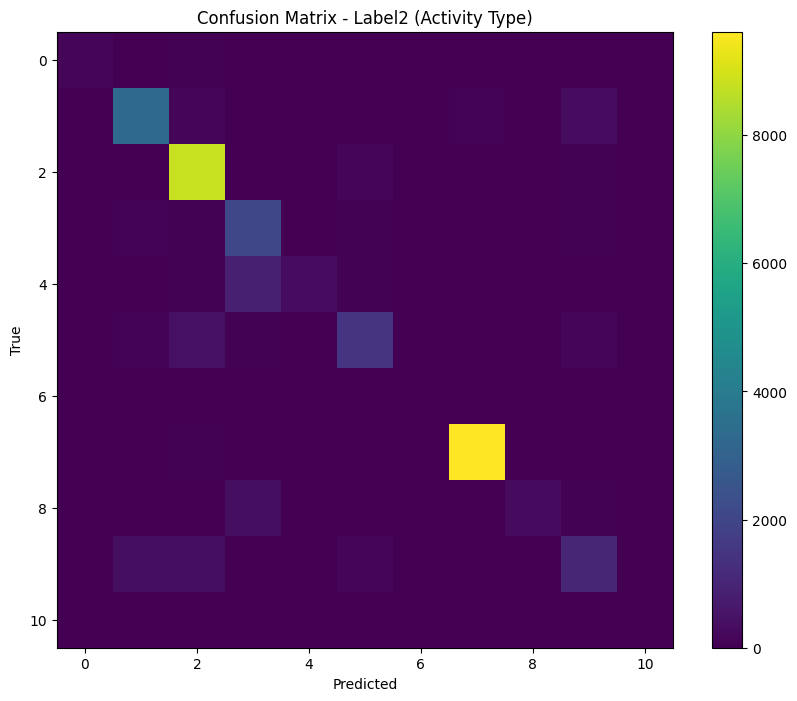

In [19]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix - Label2 (Activity Type)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [20]:
label_map = dict(zip(range(len(label2_encoder.classes_)), label2_encoder.classes_))
label_map


{0: 'AUDIO-STREAMING',
 1: 'Audio-Streaming',
 2: 'Browsing',
 3: 'Chat',
 4: 'Email',
 5: 'File-Transfer',
 6: 'File-transfer',
 7: 'P2P',
 8: 'VOIP',
 9: 'Video-Streaming',
 10: 'Video-streaming'}